# Task 6: Time Series Classification

Binary classification of ECG time series for ischemic vs non-ischemic conditions.

## 1. Setup and Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
try:
    import wfdb
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wfdb"])
    import wfdb

try:
    from tslearn.neighbors import KNeighborsTimeSeriesClassifier
    from tslearn.utils import to_time_series_dataset
    from tslearn.preprocessing import TimeSeriesScalerMeanVariance
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tslearn"])
    from tslearn.neighbors import KNeighborsTimeSeriesClassifier
    from tslearn.utils import to_time_series_dataset
    from tslearn.preprocessing import TimeSeriesScalerMeanVariance

try:
    import xgboost as xgb
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)
base_path = Path.cwd()
if base_path.name == 'code':
    base_path = base_path.parent
data_path = base_path / 'Data'
code_path = base_path / 'code'
ecg_data_path = data_path / 'time-series-project2025'

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")
print(f"ECG data path: {ecg_data_path}")

Working directory: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data
ECG data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/time-series-project2025


## 2. Load Binary Labels

Load labels using the logic from `labels_binary_classification.py`. Labels indicate whether a patient has ischemic (1) or non-ischemic (0) cardiovascular conditions.

In [43]:
diagnoses_file = data_path / "heart_diagnoses_1.csv"
icds = {
    "I20", "I21", "I22", "I24", "I25",
    "I30", "I31", "I33",
    "I34", "I35", "I36",
    "I40", "I42",
    "I44", "I45", "I46", "I47", "I48", "I49",
    "I50"
}

class1 = {"I20", "I21", "I22", "I24", "I25"}

def compute_ischemic_label(code_set: set) -> int:
    ischemic = len(code_set & class1) > 0
    return 1 if ischemic else 0

diag = pd.read_csv(diagnoses_file)
diag["subject_id"] = diag["subject_id"].astype(str).str.strip()
diag["icd_code"] = (
    diag["icd_code"]
    .astype(str)
    .str.strip()
    .str.upper()
    .replace({"": np.nan, "NAN": np.nan})
)

diag_valid = diag[diag["icd_code"].isin(icds)].copy()

if diag_valid.empty:
    raise ValueError("Problems with the format of the codes")
subject_codes = (
    diag_valid.groupby("subject_id")["icd_code"].unique().reset_index(name="icd_codes_list")
)
subject_codes["icd_codes_set"] = subject_codes["icd_codes_list"].apply(set)

subject_codes["label_ischemic"] = subject_codes["icd_codes_set"].apply(compute_ischemic_label)
patient_labels = subject_codes[["subject_id", "label_ischemic"]].copy()
patient_labels["subject_id"] = patient_labels["subject_id"].astype(int)

print(f"Total patients with labels: {len(patient_labels)}")
print(f"\nLabel distribution:")
print(patient_labels["label_ischemic"].value_counts())
print(f"\nLabel distribution (%):")
print(patient_labels["label_ischemic"].value_counts(normalize=True) * 100)

Total patients with labels: 4392

Label distribution:
label_ischemic
0    2374
1    2018
Name: count, dtype: int64

Label distribution (%):
label_ischemic
0    54.052823
1    45.947177
Name: proportion, dtype: float64


## 3. Load Time Series Data

Load ECG time series data from WFDB format files. Each patient has ECG signals with 12 channels. We'll use Lead II (channel 1) to create univariate time series.

In [44]:
def load_wfdb_ecg_data(ecg_data_path, channel_idx=1, min_samples=100):
    """
    Load ECG signals from WFDB format files.
    
    Parameters:
    -----------
    ecg_data_path : Path
        Path to the directory containing patient subdirectories
    channel_idx : int
        Index of ECG channel to extract (0-11). Default 1 (Lead II)
        Channels: 0=I, 1=II, 2=III, 3=aVR, 4=aVF, 5=aVL, 6=V1, 7=V2, 8=V3, 9=V4, 10=V5, 11=V6
    min_samples : int
        Minimum number of samples required to include a patient
    
    Returns:
    --------
    dict : Dictionary with subject_id as keys and numpy arrays (time series values) as values
    """
    time_series_dict = {}
    ecg_data_path = Path(ecg_data_path)
    
    if not ecg_data_path.exists():
        raise FileNotFoundError(f"ECG data path not found: {ecg_data_path}")
    
    # Get all patient directories
    patient_dirs = [d for d in ecg_data_path.iterdir() if d.is_dir() and '_' in d.name]
    
    print(f"Found {len(patient_dirs)} patient directories")
    print(f"Loading ECG channel {channel_idx} (Lead II)...")
    
    channel_names = ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    print(f"Extracting channel: {channel_names[channel_idx]}")
    
    loaded_count = 0
    skipped_count = 0
    
    for patient_dir in patient_dirs:
        try:
            # Extract subject_id and hadm_id from directory name (format: subject_id_hadm_id)
            parts = patient_dir.name.split('_')
            if len(parts) < 2:
                continue
            
            subject_id = int(parts[0])
            
            # Find .hea and .dat files
            hea_files = list(patient_dir.glob("*.hea"))
            if not hea_files:
                skipped_count += 1
                continue
            
            hea_file = hea_files[0]
            dat_file = hea_file.with_suffix('.dat')
            if not dat_file.exists():
                skipped_count += 1
                continue
            
            record_name = str(hea_file.with_suffix(''))
            signals, fields = wfdb.rdsamp(record_name, channels=[channel_idx])
            
            signal_data = signals[:, 0]
            
            if len(signal_data) < min_samples:
                skipped_count += 1
                continue
            time_series_dict[subject_id] = signal_data
            loaded_count += 1
            
            if loaded_count % 200 == 0:
                print(f"Loaded {loaded_count} patients...")
                
        except Exception as e:
            skipped_count += 1
            if skipped_count <= 5:
                print(f"Error loading {patient_dir.name}: {str(e)}")
            continue
    
    print(f"\nSuccessfully loaded {loaded_count} patients")
    print(f"Skipped {skipped_count} patients")
    
    return time_series_dict
ecg_time_series = load_wfdb_ecg_data(ecg_data_path, channel_idx=1, min_samples=100)

print(f"\nTotal patients with ECG time series: {len(ecg_time_series):,}")
if ecg_time_series:
    sample_subject = list(ecg_time_series.keys())[0]
    sample_ts = ecg_time_series[sample_subject]
    print(f"\nExample time series for subject {sample_subject}:")
    print(f"  Length: {len(sample_ts):,} samples")
    print(f"  First 10 values: {sample_ts[:10]}")
    print(f"  Mean: {np.mean(sample_ts):.4f}, Std: {np.std(sample_ts):.4f}")

Found 1786 patient directories
Loading ECG channel 1 (Lead II)...
Extracting channel: II
Loaded 200 patients...
Loaded 400 patients...
Loaded 600 patients...
Loaded 800 patients...
Loaded 1000 patients...
Loaded 1200 patients...
Loaded 1400 patients...
Loaded 1600 patients...

Successfully loaded 1786 patients
Skipped 0 patients

Total patients with ECG time series: 1,786

Example time series for subject 14582002:
  Length: 5,000 samples
  First 10 values: [0.03138288 0.03288712 0.02025566 0.02771502 0.03682286 0.04244828
 0.04584827 0.0411089  0.04384949 0.04778523]
  Mean: 0.0250, Std: 0.1425


## 4. Merge Time Series with Labels

Merge time series data with labels on subject_id. Keep only patients that have both time series and labels.

In [45]:
# Get subject IDs that have both time series and labels
ts_subjects = set(ecg_time_series.keys())
label_subjects = set(patient_labels["subject_id"].values)
common_subjects = ts_subjects & label_subjects

print(f"Patients with time series: {len(ts_subjects):,}")
print(f"Patients with labels: {len(label_subjects):,}")
print(f"Patients with both: {len(common_subjects):,}")

# Filter to common subjects
filtered_labels = patient_labels[patient_labels["subject_id"].isin(common_subjects)].copy()
filtered_labels = filtered_labels.sort_values("subject_id").reset_index(drop=True)

# Create arrays for time series and labels (in same order)
X_raw = []  # Raw time series
y = []      # Labels
subject_ids = []

for subject_id in filtered_labels["subject_id"].values:
    X_raw.append(ecg_time_series[subject_id])
    y.append(filtered_labels[filtered_labels["subject_id"] == subject_id]["label_ischemic"].values[0])
    subject_ids.append(subject_id)

X_raw = np.array(X_raw, dtype=object)
y = np.array(y)
subject_ids = np.array(subject_ids)

print(f"\nFinal dataset:")
print(f"  Number of samples: {len(X_raw):,}")
print(f"  Label distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"    Class {label}: {count:,} ({count/len(y)*100:.1f}%)")
ts_lengths = [len(ts) for ts in X_raw]
print(f"\nTime series length statistics:")
print(f"  Min: {min(ts_lengths):,}")
print(f"  Max: {max(ts_lengths):,}")
print(f"  Mean: {np.mean(ts_lengths):.1f}")
print(f"  Median: {np.median(ts_lengths):.1f}")
print(f"  Std: {np.std(ts_lengths):.1f}")

Patients with time series: 1,786
Patients with labels: 4,392
Patients with both: 1,184

Final dataset:
  Number of samples: 1,184
  Label distribution:
    Class 0: 609 (51.4%)
    Class 1: 575 (48.6%)

Time series length statistics:
  Min: 5,000
  Max: 5,000
  Mean: 5000.0
  Median: 5000.0
  Std: 0.0


## 5. Feature Extraction using Approximation Methods

Implement PAA (Piecewise Aggregate Approximation), SAX (Symbolic Aggregate Approximation), and DFT (Discrete Fourier Transform) for feature extraction.

In [46]:
def paa(time_series, n_segments):
    """
    Piecewise Aggregate Approximation (PAA)
    Divides time series into n_segments equal-sized segments and computes the mean of each segment.
    
    Parameters:
    -----------
    time_series : array-like
        Input time series
    n_segments : int
        Number of segments to divide the time series into
    
    Returns:
    --------
    array : PAA representation
    """
    ts = np.array(time_series)
    n = len(ts)
    
    if n_segments >= n:
        return ts
    
    # Calculate segment size
    segment_size = n / n_segments
    
    paa_values = []
    for i in range(n_segments):
        start = int(i * segment_size)
        end = int((i + 1) * segment_size)
        if i == n_segments - 1:  # Last segment includes remaining points
            end = n
        paa_values.append(np.mean(ts[start:end]))
    
    return np.array(paa_values)

def sax(time_series, n_segments, alphabet_size=4):
    """
    Symbolic Aggregate Approximation (SAX)
    First applies PAA, then converts PAA coefficients to symbols based on breakpoints.
    
    Parameters:
    -----------
    time_series : array-like
        Input time series
    n_segments : int
        Number of segments for PAA
    alphabet_size : int
        Size of alphabet (default: 4, symbols: a, b, c, d)
    
    Returns:
    --------
    array : SAX representation (symbol indices 0 to alphabet_size-1)
    """
    # Normalize time series (z-normalization)
    ts = np.array(time_series)
    if np.std(ts) == 0:
        ts_norm = ts - np.mean(ts)
    else:
        ts_norm = (ts - np.mean(ts)) / np.std(ts)
    
    # Apply PAA
    paa_values = paa(ts_norm, n_segments)
    
    from scipy.stats import norm
    breakpoints = []
    for i in range(1, alphabet_size):
        breakpoints.append(norm.ppf(i / alphabet_size))
    sax_symbols = []
    for val in paa_values:
        symbol = 0
        for i, bp in enumerate(breakpoints):
            if val > bp:
                symbol = i + 1
        sax_symbols.append(symbol)
    
    return np.array(sax_symbols)

def dft_features(time_series, n_coefficients=20):
    ts = np.array(time_series)
    fft_vals = fft(ts)
    n_coeffs = min(n_coefficients, len(fft_vals) // 2)
    dft_features = np.abs(fft_vals[:n_coeffs])
    dft_features = dft_features / len(ts)
    
    return dft_features

sample_ts = X_raw[0]
print(f"Sample time series length: {len(sample_ts)}")

paa_features = paa(sample_ts, n_segments=20)
print(f"PAA: shape {paa_features.shape}")

sax_features = sax(sample_ts, n_segments=20, alphabet_size=4)
print(f"SAX: shape {sax_features.shape}")

dft_features_sample = dft_features(sample_ts, n_coefficients=20)
print(f"DFT: shape {dft_features_sample.shape}")

Sample time series length: 5000
PAA: shape (20,)
SAX: shape (20,)
DFT: shape (20,)


In [47]:
print("Extracting features...")
n_paa_segments = 30
n_sax_segments = 30
sax_alphabet_size = 4
n_dft_coefficients = 30

X_paa = []
X_sax = []
X_dft = []

for i, ts in enumerate(X_raw):
    X_paa.append(paa(ts, n_paa_segments))
    X_sax.append(sax(ts, n_sax_segments, sax_alphabet_size))
    X_dft.append(dft_features(ts, n_dft_coefficients))
    
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{len(X_raw)} time series...")

# Convert to numpy arrays
X_paa = np.array(X_paa)
X_sax = np.array(X_sax)
X_dft = np.array(X_dft)

# Combine all features for LR and XGBoost
X_features = np.hstack([X_paa, X_sax, X_dft])

print(f"\nFeature extraction complete!")
print(f"  PAA features shape: {X_paa.shape}")
print(f"  SAX features shape: {X_sax.shape}")
print(f"  DFT features shape: {X_dft.shape}")
print(f"  Combined features shape: {X_features.shape}")

Extracting features...
  Processed 200/1184 time series...
  Processed 400/1184 time series...
  Processed 600/1184 time series...
  Processed 800/1184 time series...
  Processed 1000/1184 time series...

Feature extraction complete!
  PAA features shape: (1184, 30)
  SAX features shape: (1184, 30)
  DFT features shape: (1184, 30)
  Combined features shape: (1184, 90)


## 6. Train-Test Split

Split the data into training and testing sets with stratification to maintain class balance.

In [48]:
X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)
train_indices, test_indices = train_test_split(
    np.arange(len(X_raw)), test_size=0.2, random_state=42, stratify=y
)

X_train_raw = [X_raw[i] for i in train_indices]
X_test_raw = [X_raw[i] for i in test_indices]
y_train_ts = y[train_indices]
y_test_ts = y[test_indices]

print("Train-Test Split Complete!")
print(f"\nTraining set:")
print(f"  Samples: {len(X_train_features):,}")
print(f"  Class distribution: {np.bincount(y_train)}")
print(f"  Class distribution (%): {np.bincount(y_train) / len(y_train) * 100}")

print(f"\nTest set:")
print(f"  Samples: {len(X_test_features):,}")
print(f"  Class distribution: {np.bincount(y_test)}")
print(f"  Class distribution (%): {np.bincount(y_test) / len(y_test) * 100}")

scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

print(f"\nFeatures standardized for LR and XGBoost models.")

Train-Test Split Complete!

Training set:
  Samples: 947
  Class distribution: [487 460]
  Class distribution (%): [51.42555438 48.57444562]

Test set:
  Samples: 237
  Class distribution: [122 115]
  Class distribution (%): [51.47679325 48.52320675]

Features standardized for LR and XGBoost models.


## 7. Model Training

### 7.1 KNN with DTW Distance

In [49]:
# Parameters
target_length = 20
max_train_samples = 200
max_test_samples = 50

def downsample_time_series_stratified(time_series, target_length, random_seed=None):
    ts = np.array(time_series)
    n = len(ts)
    
    if n <= target_length:
        return ts
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_segments = target_length
    segment_size = n / n_segments
    
    sampled_indices = []
    for i in range(n_segments):
        start = int(i * segment_size)
        end = int((i + 1) * segment_size)
        if i == n_segments - 1:
            end = n
        
        if end > start:
            idx = np.random.randint(start, end)
            sampled_indices.append(idx)
    
    sampled_indices = sorted(sampled_indices)
    
    return ts[sampled_indices]

original_length = len(X_train_raw[0])
original_train_size = len(X_train_raw)
original_test_size = len(X_test_raw)

X_train_downsampled = [downsample_time_series_stratified(ts, target_length=target_length, random_seed=42+i) 
                       for i, ts in enumerate(X_train_raw)]
X_test_downsampled = [downsample_time_series_stratified(ts, target_length=target_length, random_seed=1000+i) 
                      for i, ts in enumerate(X_test_raw)]

np.random.seed(42)
train_indices = np.random.choice(len(X_train_downsampled), 
                                size=min(max_train_samples, len(X_train_downsampled)), 
                                replace=False)
test_indices = np.random.choice(len(X_test_downsampled), 
                               size=min(max_test_samples, len(X_test_downsampled)), 
                               replace=False)

X_train_downsampled = [X_train_downsampled[i] for i in train_indices]
X_test_downsampled = [X_test_downsampled[i] for i in test_indices]
y_train_ts_reduced = y_train_ts[train_indices]
y_test_ts_reduced = y_test_ts[test_indices]

X_train_padded = np.array(X_train_downsampled)
X_test_padded = np.array(X_test_downsampled)

print(f"Training: {X_train_padded.shape}, Test: {X_test_padded.shape}")
X_train_ts = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)
X_test_ts = X_test_padded.reshape(X_test_padded.shape[0], X_test_padded.shape[1], 1)

print(f"Training KNN with DTW...")
print(f"  Training samples: {X_train_ts.shape}")
print(f"  Test samples: {X_test_ts.shape}")

k_values = [3, 5, 7]
knn_models = {}
knn_predictions = {}

for k in k_values:
    print(f"\nTraining KNN with k={k}...")
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw", n_jobs=-1)
    knn.fit(X_train_ts, y_train_ts_reduced)
    knn_models[k] = knn
    
    y_pred_knn = knn.predict(X_test_ts)
    knn_predictions[k] = y_pred_knn
    
    f1 = f1_score(y_test_ts_reduced, y_pred_knn)
    acc = accuracy_score(y_test_ts_reduced, y_pred_knn)
    print(f"  k={k}: Accuracy={acc:.4f}, F1={f1:.4f}")

best_k = max(k_values, key=lambda k: f1_score(y_test_ts_reduced, knn_predictions[k]))
print(f"\nBest k: {best_k}")

knn_best = knn_models[best_k]
y_pred_knn_final = knn_predictions[best_k]

Training: (200, 20), Test: (50, 20)
Training KNN with DTW...
  Training samples: (200, 20, 1)
  Test samples: (50, 20, 1)

Training KNN with k=3...
  k=3: Accuracy=0.4800, F1=0.5357

Training KNN with k=5...
  k=5: Accuracy=0.5400, F1=0.5818

Training KNN with k=7...
  k=7: Accuracy=0.5400, F1=0.5965

Best k: 7


### 7.2 Logistic Regression

In [50]:
print("Training Logistic Regression...")

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

lr_model.fit(X_train_features_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_features_scaled)
y_pred_lr_proba = lr_model.predict_proba(X_test_features_scaled)[:, 1]

print(f"  Training accuracy: {lr_model.score(X_train_features_scaled, y_train):.4f}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"  Test F1: {f1_score(y_test, y_pred_lr):.4f}")

Training Logistic Regression...
  Training accuracy: 0.5850
  Test accuracy: 0.4895
  Test F1: 0.4937


### 7.3 XGBoost

In [51]:
print("Training XGBoost...")

pos_count = np.sum(y_train == 1)
neg_count = np.sum(y_train == 0)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(
    X_train_features_scaled, y_train,
    eval_set=[(X_test_features_scaled, y_test)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test_features_scaled)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_features_scaled)[:, 1]

print(f"  Training accuracy: {xgb_model.score(X_train_features_scaled, y_train):.4f}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"  Test F1: {f1_score(y_test, y_pred_xgb):.4f}")

Training XGBoost...
  Training accuracy: 0.9958
  Test accuracy: 0.5190
  Test F1: 0.5250


## 8. Model Evaluation

Evaluate all models using multiple metrics: accuracy, precision, recall, F1-score, and ROC-AUC. Generate confusion matrices for each model.

In [52]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name=""):
    """Evaluate a classification model and return metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    if 'roc_auc' in metrics:
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"\n  Confusion Matrix:")
    print(f"    {cm}")
    
    return metrics, cm

print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

knn_metrics, knn_cm = evaluate_model(
    y_test_ts_reduced, y_pred_knn_final,
    model_name="KNN with DTW (k={})".format(best_k)
)

lr_metrics, lr_cm = evaluate_model(
    y_test, y_pred_lr, y_pred_lr_proba,
    model_name="Logistic Regression"
)

xgb_metrics, xgb_cm = evaluate_model(
    y_test, y_pred_xgb, y_pred_xgb_proba,
    model_name="XGBoost"
)
results = {
    'KNN (DTW)': knn_metrics,
    'Logistic Regression': lr_metrics,
    'XGBoost': xgb_metrics
}

confusion_matrices = {
    'KNN (DTW)': knn_cm,
    'Logistic Regression': lr_cm,
    'XGBoost': xgb_cm
}

MODEL EVALUATION

KNN with DTW (k=7) Results:
  Accuracy:  0.5400
  Precision: 0.6071
  Recall:    0.5862
  F1-Score:  0.5965

  Confusion Matrix:
    [[10 11]
 [12 17]]

Logistic Regression Results:
  Accuracy:  0.4895
  Precision: 0.4758
  Recall:    0.5130
  F1-Score:  0.4937
  ROC-AUC:   0.4786

  Confusion Matrix:
    [[57 65]
 [56 59]]

XGBoost Results:
  Accuracy:  0.5190
  Precision: 0.5040
  Recall:    0.5478
  F1-Score:  0.5250
  ROC-AUC:   0.5135

  Confusion Matrix:
    [[60 62]
 [52 63]]


## 9. Comparison and Visualization

In [53]:
comparison_df = pd.DataFrame(results).T
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(comparison_df.round(4))

best_model_name = comparison_df['f1'].idxmax()
best_f1 = comparison_df['f1'].max()
print(f"\nBest model: {best_model_name} (F1 = {best_f1:.4f})")


MODEL COMPARISON
                     accuracy  precision  recall      f1  roc_auc
KNN (DTW)              0.5400     0.6071  0.5862  0.5965      NaN
Logistic Regression    0.4895     0.4758  0.5130  0.4937   0.4786
XGBoost                0.5190     0.5040  0.5478  0.5250   0.5135

Best model: KNN (DTW) (F1 = 0.5965)


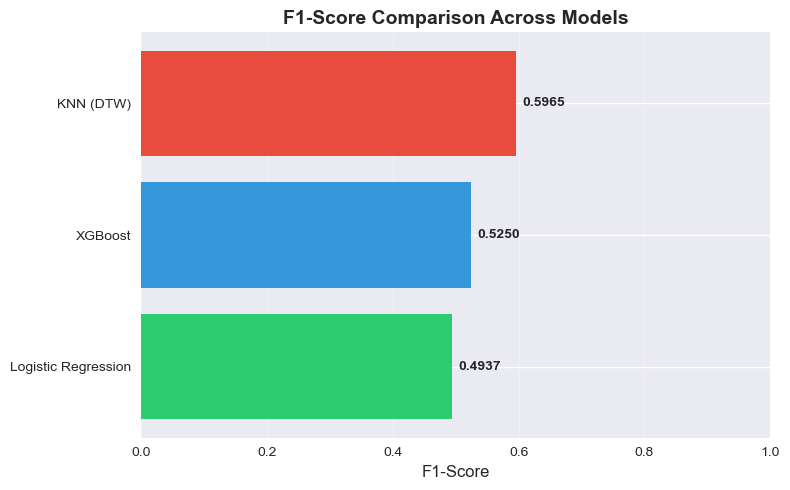

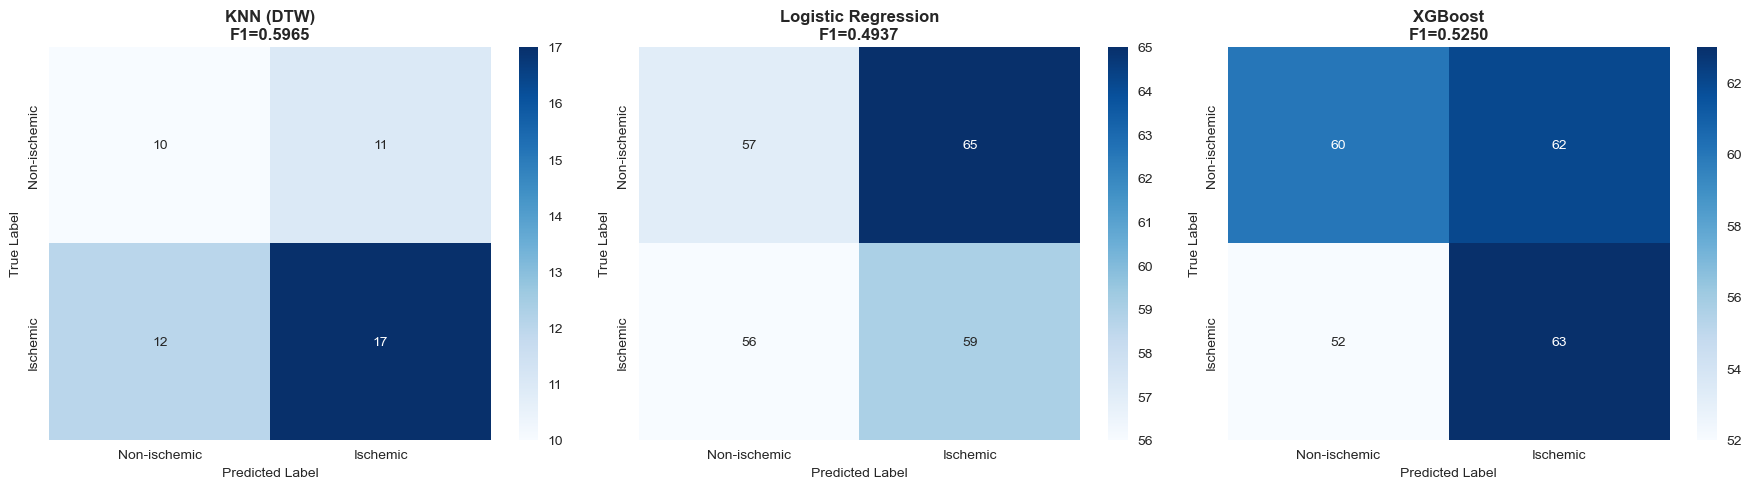

In [54]:
fig1, ax1 = plt.subplots(figsize=(8, 5))
f1_scores = comparison_df['f1'].sort_values(ascending=True)
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax1.barh(f1_scores.index, f1_scores.values, color=colors[:len(f1_scores)])
ax1.set_xlabel('F1-Score', fontsize=12)
ax1.set_title('F1-Score Comparison Across Models', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1])
ax1.grid(axis='x', alpha=0.3)

for i, (idx, val) in enumerate(f1_scores.items()):
    ax1.text(val + 0.01, i, f'{val:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('6.tsc_f1_scores.png', dpi=300, bbox_inches='tight')
plt.show()

fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes2[idx],
                xticklabels=['Non-ischemic', 'Ischemic'],
                yticklabels=['Non-ischemic', 'Ischemic'])
    axes2[idx].set_title(f'{model_name}\nF1={results[model_name]["f1"]:.4f}', 
                        fontsize=12, fontweight='bold')
    axes2[idx].set_ylabel('True Label', fontsize=10)
    axes2[idx].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.savefig('6.tsc_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

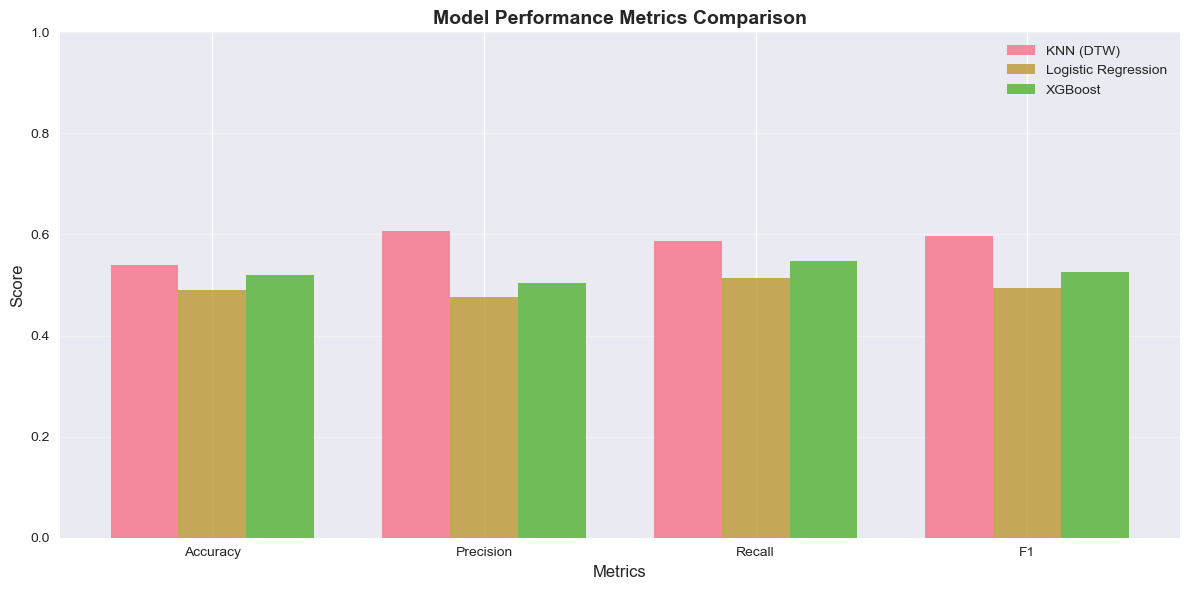

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, model_name in enumerate(comparison_df.index):
    values = [comparison_df.loc[model_name, metric] for metric in metrics_to_plot]
    offset = (i - 1) * width
    ax.bar(x + offset, values, width, label=model_name, alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_to_plot])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('6.tsc_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

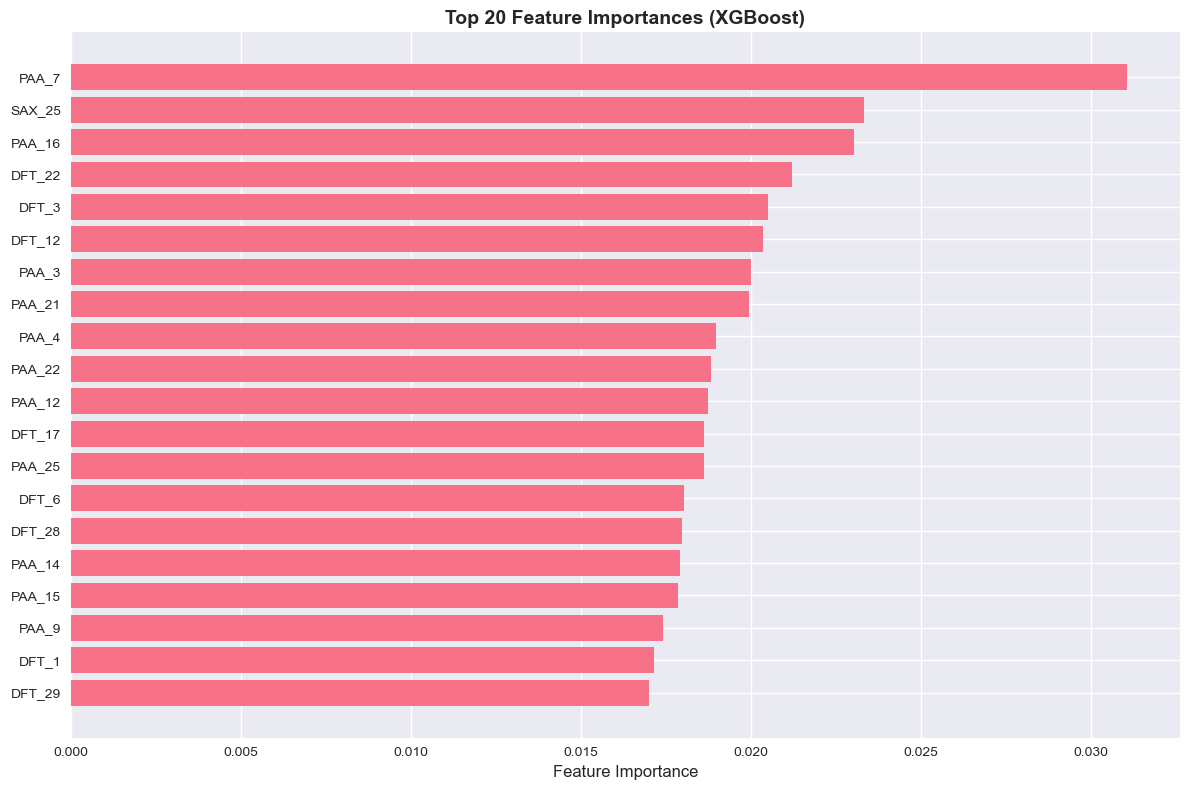


Top 10 Most Important Features:
  1. PAA_7: 0.0311
  2. SAX_25: 0.0233
  3. PAA_16: 0.0231
  4. DFT_22: 0.0212
  5. DFT_3: 0.0205
  6. DFT_12: 0.0204
  7. PAA_3: 0.0200
  8. PAA_21: 0.0199
  9. PAA_4: 0.0190
  10. PAA_22: 0.0188


In [56]:
if hasattr(xgb_model, 'feature_importances_'):
    feature_names = (
        [f'PAA_{i}' for i in range(n_paa_segments)] +
        [f'SAX_{i}' for i in range(n_sax_segments)] +
        [f'DFT_{i}' for i in range(n_dft_coefficients)]
    )
    
    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)[::-1][:20]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(range(len(indices)), importances[indices], align='center')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Feature Importance', fontsize=12)
    ax.set_title('Top 20 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig('6.tsc_feature_importances.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    for i, idx in enumerate(indices[:10]):
        print(f"  {i+1}. {feature_names[idx]}: {importances[idx]:.4f}")